## Importo Librerias y Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np 
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, LSTM, SpatialDropout1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import nltk
from keras.layers import Input
from nltk import word_tokenize
from sklearn import preprocessing
from numpy import array
from keras.layers.core import Activation
from keras.models import Model
from keras.layers.merge import Concatenate
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-12-20 17:25:21--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-12-20 17:25:21--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-20 17:25:21--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

In [ ]:
items_df = pd.read_csv("/content/gdrive/MyDrive/Orga_Datos/TP4/silkroad_items.csv",usecols=["title","description","category"])

## Baseline

In [ ]:
#
79943/401094

0.19931238063895246

In [ ]:
items_df['category_id'] = items_df['category'].factorize()[0]

In [ ]:
mode = items_df.category_id.mode()[0]

In [ ]:
accuracy_score(items_df['category_id'], [mode for _ in range(len(items_df))])

0.19931238063895246

## Preprocesing

### Divido entre X e Y

In [ ]:
X = items_df.drop(['category','category_id'], axis=1)

In [ ]:
y = items_df['category']

In [ ]:
label_encoder = preprocessing.LabelEncoder()

In [ ]:
y = label_encoder.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(360984, 2) (360984, 305)
(40110, 2) (40110, 305)


### Titulos

In [ ]:
X1_train_tit = []
sentences = list(X_train["title"])
for sen in sentences:
    X1_train_tit.append(sen)

In [ ]:
X1_test_tit = []
sentences = list(X_test["title"])
for sen in sentences:
    X1_test_tit.append(sen)

In [ ]:
tokenizer_tit = Tokenizer(num_words=5000)
tokenizer_tit.fit_on_texts(X1_train_tit)

In [ ]:
X1_train_tit = tokenizer_tit.texts_to_sequences(X1_train_tit)
X1_test_tit = tokenizer_tit.texts_to_sequences(X1_test_tit)

In [ ]:
vocab_size_tit = len(tokenizer_tit.word_index) + 1
maxlen_tit = 5

In [ ]:
X1_train_tit = pad_sequences(X1_train_tit, padding='post', maxlen=maxlen_tit)
X1_test_tit = pad_sequences(X1_test_tit, padding='post', maxlen=maxlen_tit)

In [ ]:
embedding_matrix_1 = np.zeros((vocab_size_tit, 100))
for word, index in tokenizer_tit.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix_1[index] = embedding_vector

### Descriptions

In [ ]:
X2_train_desc = []
sentences = list(X_train["description"])
for sen in sentences:
    X2_train_desc.append(sen)

In [ ]:
X2_test_desc = []
sentences = list(X_test["description"])
for sen in sentences:
    X2_test_desc.append(sen)

In [ ]:
tokenizer_desc = Tokenizer(num_words=50000)
tokenizer_desc.fit_on_texts(X2_train_desc)

In [ ]:
X2_train_desc = tokenizer_desc.texts_to_sequences(X2_train_desc)
X2_test_desc = tokenizer_desc.texts_to_sequences(X2_test_desc)

In [ ]:
vocab_size_desc = len(tokenizer_desc.word_index) + 1
maxlen_desc = 100

In [ ]:
X2_train_desc = pad_sequences(X2_train_desc, padding='post', maxlen=maxlen_desc)
X2_test_desc = pad_sequences(X2_test_desc, padding='post', maxlen=maxlen_desc)

In [ ]:
embedding_matrix_2 = np.zeros((vocab_size_desc, 100))
for word, index in tokenizer_desc.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix_2[index] = embedding_vector

## Entrenamiento

### Titles

In [ ]:
input_1 = Input(shape=(maxlen_tit,))

In [ ]:
layer_1a = Embedding(vocab_size_tit,100,weights=[embedding_matrix_1], trainable=False, input_length=X.shape[1])(input_1)
layer_1b = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(layer_1a)

### Descriptions

In [ ]:
input_2 = Input(shape=(maxlen_desc,))

In [ ]:
layer_2a = Embedding(vocab_size_desc,100,weights=[embedding_matrix_2], trainable=False, input_length=X.shape[1])(input_2)
layer_2b= LSTM(128, dropout=0.2, recurrent_dropout=0.2)(layer_2a)

### Concatenate

In [ ]:
concat_layer = Concatenate()([layer_1b, layer_2b])
output = Dense(305, activation='softmax')(concat_layer)
model = Model(inputs=[input_1, input_2], outputs=output)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 5, 100)       1303400     ['input_2[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 100)     7604400     ['input_3[0][0]']                
                                                                                            

In [ ]:
history = model.fit(x=[X1_train_tit, X2_train_desc], y=y_train, batch_size=256, epochs=10, verbose=1, validation_split=0.1)

Epoch 1/10
  83/1270 [>.............................] - ETA: 25:42 - loss: 3.7717 - acc: 0.2385

KeyboardInterrupt: ignored

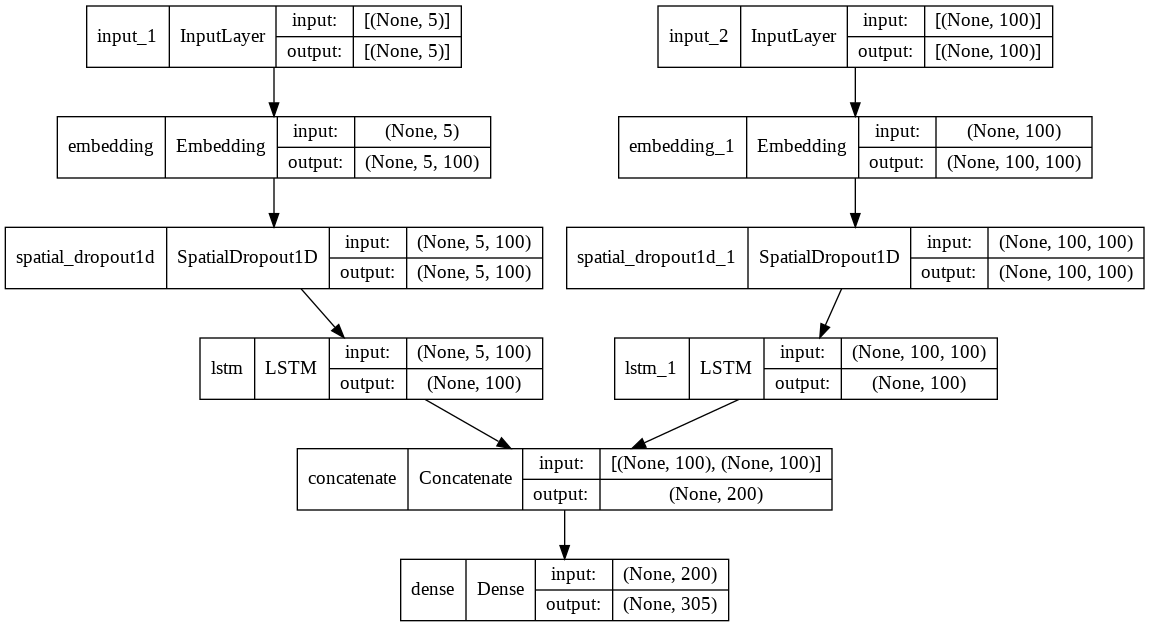

In [ ]:
plot_model(model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

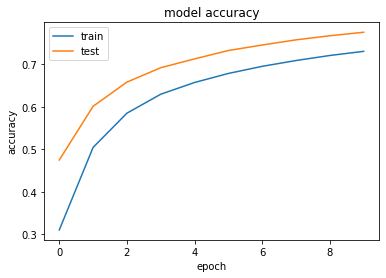

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')

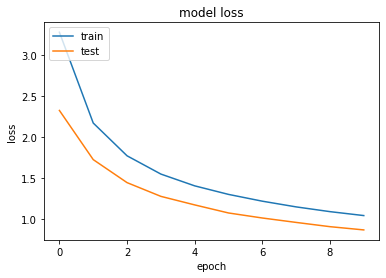

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')

In [ ]:
score = model.evaluate(x=[X1_test_tit, X2_test_desc], y=y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

 403/1254 [========>.....................] - ETA: 42s - loss: 3.0549 - acc: 0.3415

KeyboardInterrupt: ignored

## Versus Dataset

In [ ]:
versus_df = pd.read_csv("/content/gdrive/MyDrive/Orga_Datos/TP4/versus.csv",usecols=["Category","title"])

In [ ]:
versus_df.columns = ["title","category"]

In [ ]:
versus_df.head()

,title,category
0,1oz. Distillate(FLAVORED),Concentrates
1,***3G for the price of 2G***,Cocaine
2,RAW THC DISTILLATE 1L (1000ml) $3 per gram Don...,Concentrates
3,**Free** Colombian Coke Giveaway! 3.5G + 0.5G ...,Cocaine
4,***OPENING SALE 3.5G PURE CHAMPAGNE MDMA***,MDMA


In [ ]:
versus_df.category.value_counts()

Buds & Flowers       1864
Pills                1610
Cocaine              1002
LSD                   988
Ketamin               839
                     ... 
Other Legal Items       1
Games Keys              1
Digital                 1
Exploit Kits            1
Electronics             1
Name: category, Length: 90, dtype: int64

In [ ]:
X_test_ver_tit = []
sentences = list(versus_df["title"])
for sen in sentences:
    X_test_ver_tit.append(sen)

In [ ]:
tokenizer_ver = Tokenizer(num_words=5000)
tokenizer_ver.fit_on_texts(X_test_ver_tit)

In [ ]:
tokenizer_tit.fit_on_texts(X_test_ver_tit)

In [ ]:
X_test_ver_tit = tokenizer_tit.texts_to_sequences(X_test_ver_tit)

In [ ]:
vocab_size_ver = len(tokenizer_ver.word_index) + 1
maxlen_ver = 5

In [ ]:
X_test_ver_tit = pad_sequences(X_test_ver_tit, padding='post', maxlen=maxlen_ver)

In [ ]:
label_encoder = preprocessing.LabelEncoder()

In [ ]:
y_test_ver = versus_df['category']

In [ ]:
y_test_ver = label_encoder.fit_transform(y_test_ver)

In [ ]:
y_test_ver = to_categorical(y_test_ver)

In [ ]:
X_test_ver

array([[ 241, 3701, 1198,    0,    0],
       [  34,   29,  130,    6,  124],
       [  15,  186,   23, 4781,  128],
       ...,
       [  23,  109,  181,   87, 4765],
       [1565,  101, 3329,   54,  135],
       [ 763,  745,   22, 2610,    0]], dtype=int32)

In [ ]:
y_test_ver.shape

(16015, 90)

In [ ]:
score = model.evaluate(x=[X_test_ver_tit, X_test_ver_desc], y=y_test_ver, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

ValueError: ignored

In [ ]:
X1_train_tit.shape

(360984, 5)

In [ ]:
X2_test_desc.shape

(40110, 100)

In [ ]:
X_test_ver_tit.shape

(16015, 5)

In [ ]:
X_test_ver_desc = np.zeros(shape=(40000,100))

In [ ]:
y_test_ver

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
import pickle

In [ ]:
with open('model_backup', 'wb') as model_backup_file:
    pickle.dump(model, model_backup_file)

INFO:tensorflow:Assets written to: ram://7d9b0889-2b31-4eea-8f5e-9055cc6d6706/assets


In [ ]:
loaded_model = pickle.load(open("model_backup", 'rb'))

In [ ]:
loaded_model2 = pickle.load(open("/content/model_backup", 'rb'))

UnpicklingError: ignored